### Лабораторная работа №8 (Проведение исследований моделями обнаружения и распознавания объектов)

## 1. Выбор начальных условий

# a. Набор данных

Данные https://www.kaggle.com/datasets/issaisasank/guns-object-detection/data

Этот датасет представляет собой набор данных для обнаружения огнестрельного оружия, что делает его актуальным для задач обеспечения безопасности и мониторинга (например, для систем видеонаблюдения)

In [1]:
!pip install kaggle

In [2]:
!pip install opendatasets
!pip install pandas

In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/issaisasank/guns-object-detection/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kirillzhur
Your Kaggle Key: ··········
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/issaisasank/guns-object-detection


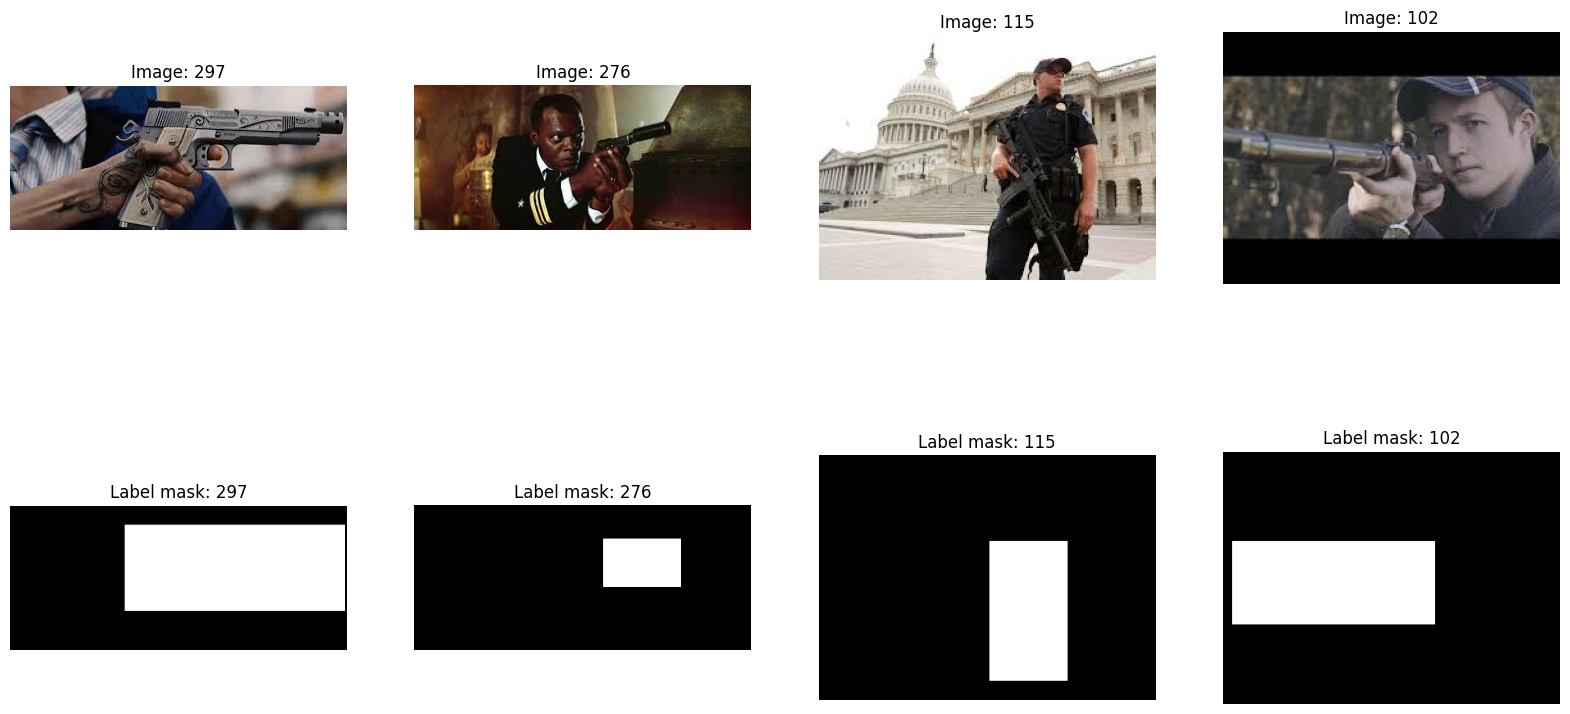

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image

BASE_IMAGE_PATH = "/content/guns-object-detection/Images"
BASE_LABELS_PATH = "/content/guns-object-detection/Labels"

image_data = []
image_labels = []

image_count = len(os.listdir(BASE_IMAGE_PATH))

for i in range(1, image_count + 1):
    image_path = os.path.join(BASE_IMAGE_PATH, f"{i}.jpeg")
    img = read_image(image_path)
    image_data.append(img)

    _, H, W = img.shape
    label_mask = torch.zeros((H, W), dtype=torch.float32)

    label_path = os.path.join(BASE_LABELS_PATH, f"{i}.txt")
    with open(label_path, 'r') as label_file:
        l_count = int(label_file.readline().strip())
        for j in range(l_count):
            box = list(map(int, label_file.readline().split()))
            label_mask[box[1]:box[3], box[0]:box[2]] = 1.0

    image_labels.append(label_mask)

plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for idx, img_index in enumerate(np.random.randint(0, image_count, size=4)):
    plt.subplot(2, 4, idx + 1)
    plt.axis('off')
    plt.title(f'Image: {img_index}')
    img_np = image_data[img_index].permute(1, 2, 0).numpy()
    plt.imshow(img_np)

    plt.subplot(2, 4, idx + 5)
    plt.axis('off')
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index].numpy(), cmap='gray')

plt.show()


# b. Метрики качества


Mean Average Precision (mAP):

Основная метрика для задач обнаружения объектов. mAP рассчитывается как среднее значение AP (Average Precision) по всем классам. При использовании одного класса (оружие) mAP может давать представление о том, насколько точно и полно модель обнаруживает оружие.

Precision и Recall:

Эти метрики помогут понять, насколько модель точна в своих предсказаниях (precision) и насколько полно она обнаруживает объекты (recall). Особенно важно в сценариях, связанных с безопасностью, где необходимо минимизировать как ложные срабатывания, так и пропуски.

## 2. Создание бейзлана и оценка качества

в качестве базовой модели будем использовать  YOLOv8

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import os
import cv2

def convert_bbox(size, box):
    img_w, img_h = size
    dw = 1.0 / img_w
    dh = 1.0 / img_h
    xmin, ymin, xmax, ymax = box
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    w = xmax - xmin
    h = ymax - ymin
    return (x_center * dw, y_center * dh, w * dw, h * dh)

image_dir = '/content/guns-object-detection/Images'
label_dir = '/content/guns-object-detection/Labels'
output_label_dir = '/content/guns-object-detection/Labels_YOLO'

os.makedirs(output_label_dir, exist_ok=True)

for label_file in os.listdir(label_dir):
    if not label_file.endswith('.txt'):
        continue
    label_path = os.path.join(label_dir, label_file)

    with open(label_path, 'r') as f:
        lines = f.readlines()

    try:
        count = int(lines[0].strip())
    except ValueError:
        print(f"Проблема с файлом {label_file}: первая строка не является числом.")
        continue

    boxes = []
    for line in lines[1:]:
        parts = line.strip().split()
        if len(parts) != 4:
            print(f"Некорректная строка в {label_file}: {line.strip()}")
            continue
        box = list(map(int, parts))
        boxes.append(box)


    base_name = os.path.splitext(label_file)[0]
    image_path = os.path.join(image_dir, base_name + '.jpeg')
    if not os.path.exists(image_path):
        image_path = os.path.join(image_dir, base_name + '.jpg')
    if not os.path.exists(image_path):
        print(f"Изображение для файла {label_file} не найдено.")
        continue

    img = cv2.imread(image_path)
    if img is None:
        print(f"Не удалось открыть изображение {image_path}.")
        continue
    height, width = img.shape[:2]


    yolo_lines = []
    for box in boxes:
        x_center, y_center, w, h = convert_bbox((width, height), box)
        yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

    output_path = os.path.join(output_label_dir, label_file)
    with open(output_path, 'w') as f:
        for line in yolo_lines:
            f.write(line + "\n")

    print(f"Файл {label_file} преобразован и сохранён в {output_label_dir}")


In [ ]:
import os
import random
import shutil

source_images = '/content/guns-object-detection/Images'
source_labels = '/content/guns-object-detection/Labels_YOLO'

dest_train_images = '/content/guns-object-detection/dataset/train/images'
dest_train_labels = '/content/guns-object-detection/dataset/train/labels'
dest_val_images   = '/content/guns-object-detection/dataset/val/images'
dest_val_labels   = '/content/guns-object-detection/dataset/val/labels'

os.makedirs(dest_train_images, exist_ok=True)
os.makedirs(dest_train_labels, exist_ok=True)
os.makedirs(dest_val_images, exist_ok=True)
os.makedirs(dest_val_labels, exist_ok=True)

all_images = [f for f in os.listdir(source_images)
              if f.lower().endswith(('.jpeg'))]
all_images.sort()

random.seed(42)
random.shuffle(all_images)

train_ratio = 0.8
split_index = int(len(all_images) * train_ratio)
train_files = all_images[:split_index]
val_files   = all_images[split_index:]

print(f'Всего изображений: {len(all_images)}')
print(f'Изображений для train: {len(train_files)}')
print(f'Изображений для val: {len(val_files)}')


for f in train_files:

    src_img = os.path.join(source_images, f)
    dst_img = os.path.join(dest_train_images, f)
    shutil.copy(src_img, dst_img)

    label_filename = os.path.splitext(f)[0] + '.txt'
    src_label = os.path.join(source_labels, label_filename)
    dst_label = os.path.join(dest_train_labels, label_filename)
    if os.path.exists(src_label):
        shutil.copy(src_label, dst_label)
    else:
        print(f'Внимание: файл разметки для {f} не найден!')

for f in val_files:
    src_img = os.path.join(source_images, f)
    dst_img = os.path.join(dest_val_images, f)
    shutil.copy(src_img, dst_img)

    label_filename = os.path.splitext(f)[0] + '.txt'
    src_label = os.path.join(source_labels, label_filename)
    dst_label = os.path.join(dest_val_labels, label_filename)
    if os.path.exists(src_label):
        shutil.copy(src_label, dst_label)
    else:
        print(f'Внимание: файл разметки для {f} не найден!')


Всего изображений: 333
Изображений для train: 266
Изображений для val: 67


In [ ]:
import yaml

dataset_yaml = {
    'train': '/content/guns-object-detection/dataset/train/images',
    'val': '/content/guns-object-detection/dataset/val/images',
    'nc': 1,
    'names': ['gun']
}

yaml_path = '/content/guns-object-detection/dataset/guns_dataset.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(dataset_yaml, file, default_flow_style=False)

print(f"YAML-конфигурация сохранена по пути: {yaml_path}")

YAML-конфигурация сохранена по пути: /content/guns-object-detection/dataset/guns_dataset.yaml


In [ ]:
import os

labels_dir = '/content/guns-object-detection/dataset/train/labels'
for label_file in os.listdir(labels_dir):
    path = os.path.join(labels_dir, label_file)
    with open(path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            values = line.strip().split()
            if len(values) != 5:
                print(f"Некорректная строка в {label_file}: {line}")


In [ ]:
from ultralytics import YOLO


model = YOLO("yolov8n.pt")

results_train = model.train(data=yaml_path, epochs=50, imgsz=640)

results_val = model.val(data=yaml_path, iou=0.5)

results_val.print()



Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/guns-object-detection/dataset/guns_dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /content/guns-object-detection/dataset/train/labels... 266 images, 0 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<00:00, 2271.27it/s]

train: New cache created: /content/guns-object-detection/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/guns-object-detection/dataset/val/labels... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<00:00, 915.44it/s]

val: New cache created: /content/guns-object-detection/dataset/val/labels.cache


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.06G      1.837      3.114       1.71         22        640: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         67         84    0.00403      0.964      0.355      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.55G      1.631      2.304      1.554         24        640: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

                   all         67         84    0.00378      0.905      0.183     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.58G      1.674      2.187      1.603         25        640: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         67         84      0.355     0.0595     0.0982      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.6G       1.67      2.186      1.597         26        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]

                   all         67         84       0.45      0.202      0.197     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.61G      1.729       2.12      1.638         27        640: 100%|██████████| 17/17 [00:04<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         67         84      0.187     0.0833     0.0549     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.63G      1.697        2.1       1.58         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]

                   all         67         84      0.155      0.179     0.0724     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.65G      1.669      2.011      1.554         19        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]

                   all         67         84      0.357      0.238      0.211      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.67G      1.695      1.972      1.587         29        640: 100%|██████████| 17/17 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         67         84      0.233       0.19      0.122     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.67G       1.67      1.878      1.579         24        640: 100%|██████████| 17/17 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         67         84      0.177      0.392      0.146     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.7G      1.718      1.853      1.609         24        640: 100%|██████████| 17/17 [00:03<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         67         84      0.287      0.393      0.272      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.72G      1.665      1.698      1.579         28        640: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]

                   all         67         84      0.306      0.429       0.32      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.74G       1.62      1.759      1.566         19        640: 100%|██████████| 17/17 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         67         84      0.469      0.476      0.502      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.74G      1.595      1.576      1.516         26        640: 100%|██████████| 17/17 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         67         84      0.516      0.495      0.503      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.77G      1.565       1.52      1.488         20        640: 100%|██████████| 17/17 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]

                   all         67         84      0.524      0.432      0.468      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.79G      1.523      1.482      1.454         25        640: 100%|██████████| 17/17 [00:04<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         67         84      0.373      0.405      0.339      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       2.8G      1.539      1.434      1.472         19        640: 100%|██████████| 17/17 [00:04<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         67         84      0.399      0.405      0.418      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.81G      1.536      1.299      1.475         28        640: 100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all         67         84       0.88      0.523      0.629      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.84G      1.492       1.31      1.447         22        640: 100%|██████████| 17/17 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         67         84      0.765       0.56      0.633      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.86G      1.465      1.278      1.415         21        640: 100%|██████████| 17/17 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         67         84      0.873      0.512      0.659      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.87G      1.454      1.256      1.418         25        640: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]

                   all         67         84      0.841       0.56      0.688      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.88G      1.491      1.263      1.452         26        640: 100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]

                   all         67         84      0.766      0.619      0.702      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.91G      1.485      1.248      1.459         35        640: 100%|██████████| 17/17 [00:04<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

                   all         67         84      0.779      0.595      0.711      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.92G      1.407      1.143      1.373         31        640: 100%|██████████| 17/17 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

                   all         67         84      0.728      0.638      0.749       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.94G      1.436      1.199      1.393         24        640: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         67         84      0.679      0.605      0.657      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.95G      1.413      1.166      1.392         20        640: 100%|██████████| 17/17 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         67         84      0.764      0.577      0.659      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.97G      1.363        1.1      1.333         25        640: 100%|██████████| 17/17 [00:05<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         67         84      0.761      0.645      0.707      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.99G      1.381      1.072      1.344         30        640: 100%|██████████| 17/17 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all         67         84      0.758      0.714      0.787      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.01G      1.336      1.084      1.317         29        640: 100%|██████████| 17/17 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]

                   all         67         84      0.844      0.709      0.782      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.02G      1.292      1.034      1.308         39        640: 100%|██████████| 17/17 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]

                   all         67         84      0.833      0.714      0.783      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.04G      1.319     0.9948      1.329         25        640: 100%|██████████| 17/17 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]

                   all         67         84      0.784      0.648      0.759      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.06G      1.337      1.018      1.342         28        640: 100%|██████████| 17/17 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.10it/s]

                   all         67         84      0.815      0.702      0.777      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.08G      1.299     0.9846      1.294         43        640: 100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]

                   all         67         84      0.796      0.667      0.787      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.08G      1.303      0.978        1.3         25        640: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         67         84      0.817      0.637      0.766      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.11G      1.257     0.9535      1.273         32        640: 100%|██████████| 17/17 [00:03<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all         67         84      0.795      0.691      0.757      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.13G      1.242     0.9374      1.285         19        640: 100%|██████████| 17/17 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         67         84      0.881      0.655      0.779      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.14G      1.229     0.8768      1.277         25        640: 100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         67         84      0.806      0.774      0.817      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.15G      1.204     0.8986      1.247         30        640: 100%|██████████| 17/17 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.82it/s]

                   all         67         84      0.868      0.704      0.798      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.18G      1.169     0.8934      1.231         32        640: 100%|██████████| 17/17 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]

                   all         67         84      0.862      0.667      0.771      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.2G       1.16     0.8602      1.214         33        640: 100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         67         84      0.832      0.714      0.798      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.21G      1.196     0.8796      1.239         25        640: 100%|██████████| 17/17 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]

                   all         67         84      0.918       0.69      0.822      0.383


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.22G      1.084     0.7602      1.167         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all         67         84      0.876      0.667       0.79      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.25G      1.087     0.7937      1.173         12        640: 100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]

                   all         67         84      0.908      0.706      0.825      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.27G      1.019     0.6907      1.148         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.21it/s]

                   all         67         84      0.865      0.702      0.814      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.28G      1.034     0.6919      1.172         14        640: 100%|██████████| 17/17 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]

                   all         67         84      0.842       0.75      0.819      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.29G      1.039     0.6913      1.157         12        640: 100%|██████████| 17/17 [00:04<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]

                   all         67         84       0.87      0.738      0.824      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.32G      1.007     0.6536      1.124         11        640: 100%|██████████| 17/17 [00:04<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]

                   all         67         84      0.892      0.692      0.806      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.33G     0.9887     0.6533       1.13         11        640: 100%|██████████| 17/17 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.20it/s]

                   all         67         84      0.871      0.679      0.795      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.35G     0.9608     0.6357      1.119         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.16it/s]

                   all         67         84       0.79      0.716      0.798      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.36G     0.9194     0.6143      1.086         12        640: 100%|██████████| 17/17 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

                   all         67         84      0.891      0.714      0.832       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.38G     0.9631     0.6171      1.097         13        640: 100%|██████████| 17/17 [00:04<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         67         84      0.878      0.726      0.828      0.388



50 epochs completed in 0.077 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]


                   all         67         84      0.869      0.738      0.824      0.396
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train6
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/guns-object-detection/dataset/val/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


                   all         67         84      0.926      0.726      0.826      0.393
Speed: 1.0ms preprocess, 10.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train62


AttributeError: 'DetMetrics' object has no attribute 'print'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (dict): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (dict): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

In [ ]:
results_val = model.val(data=yaml_path, iou=0.5)

print("Precision:", results_val.box.p)
print("Recall:", results_val.box.r)
print("mAP@0.5:", results_val.box.map50)
print("mAP@0.5:0.95:", results_val.box.map)

Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/guns-object-detection/dataset/val/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


                   all         67         84      0.926      0.726      0.826      0.393
Speed: 3.2ms preprocess, 4.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train64
Precision: [    0.92598]
Recall: [    0.72619]
mAP@0.5: 0.8258042961874026
mAP@0.5:0.95: 0.3930564976089782


## 3. Улучшение бейзлайна

для улучшение бейзлайна подберем гиперпараметры

In [ ]:
model = YOLO("yolov8n.pt")

results = model.train(
    data='/content/guns-object-detection/dataset/guns_dataset.yaml',
    epochs=50,
    imgsz=640,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    mosaic=1.0,
    mixup=0.0
)

Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/guns-object-detection/dataset/guns_dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /content/guns-object-detection/dataset/train/labels.cache... 266 images, 0 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/guns-object-detection/dataset/val/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.23G      1.837      3.114       1.71         22        640: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]

                   all         67         84    0.00403      0.964      0.355      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.39G      1.631      2.304      1.554         24        640: 100%|██████████| 17/17 [00:03<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         67         84    0.00378      0.905      0.183     0.0737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.39G      1.674      2.187      1.603         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67         84      0.355     0.0595     0.0982      0.032



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.39G       1.67      2.186      1.597         26        640: 100%|██████████| 17/17 [00:03<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]

                   all         67         84       0.45      0.202      0.197     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.39G      1.729       2.12      1.638         27        640: 100%|██████████| 17/17 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         67         84      0.187     0.0833     0.0549     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.39G      1.697        2.1       1.58         25        640: 100%|██████████| 17/17 [00:03<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         67         84      0.155      0.179     0.0724     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.39G      1.669      2.011      1.554         19        640: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         67         84      0.357      0.238      0.211      0.071



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.39G      1.695      1.972      1.587         29        640: 100%|██████████| 17/17 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.68it/s]

                   all         67         84      0.233       0.19      0.122     0.0483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.39G       1.67      1.878      1.579         24        640: 100%|██████████| 17/17 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.63it/s]

                   all         67         84      0.177      0.392      0.146     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.39G      1.718      1.853      1.609         24        640: 100%|██████████| 17/17 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.64it/s]

                   all         67         84      0.287      0.393      0.272      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.39G      1.665      1.698      1.579         28        640: 100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all         67         84      0.306      0.429       0.32      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.39G       1.62      1.759      1.566         19        640: 100%|██████████| 17/17 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         67         84      0.469      0.476      0.502      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.39G      1.595      1.576      1.516         26        640: 100%|██████████| 17/17 [00:04<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all         67         84      0.516      0.495      0.503      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.39G      1.565       1.52      1.488         20        640: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         67         84      0.524      0.432      0.468      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.39G      1.523      1.482      1.454         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.38it/s]

                   all         67         84      0.373      0.405      0.339      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.39G      1.539      1.434      1.472         19        640: 100%|██████████| 17/17 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]

                   all         67         84      0.399      0.405      0.418      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.39G      1.536      1.299      1.475         28        640: 100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         67         84       0.88      0.523      0.629      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.39G      1.492       1.31      1.447         22        640: 100%|██████████| 17/17 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67         84      0.765       0.56      0.633      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.39G      1.465      1.278      1.415         21        640: 100%|██████████| 17/17 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.66it/s]

                   all         67         84      0.873      0.512      0.659      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.39G      1.454      1.256      1.418         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         67         84      0.841       0.56      0.688      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.39G      1.491      1.263      1.452         26        640: 100%|██████████| 17/17 [00:03<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         67         84      0.766      0.619      0.702      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.39G      1.485      1.248      1.459         35        640: 100%|██████████| 17/17 [00:04<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]

                   all         67         84      0.779      0.595      0.711      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.39G      1.407      1.143      1.373         31        640: 100%|██████████| 17/17 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]

                   all         67         84      0.728      0.638      0.749       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.39G      1.436      1.199      1.393         24        640: 100%|██████████| 17/17 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all         67         84      0.679      0.605      0.657      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.39G      1.413      1.166      1.392         20        640: 100%|██████████| 17/17 [00:04<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all         67         84      0.764      0.577      0.659      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.39G      1.363        1.1      1.333         25        640: 100%|██████████| 17/17 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.51it/s]

                   all         67         84      0.761      0.645      0.707      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.39G      1.381      1.072      1.344         30        640: 100%|██████████| 17/17 [00:04<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         67         84      0.758      0.714      0.787      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.39G      1.336      1.084      1.317         29        640: 100%|██████████| 17/17 [00:03<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.83it/s]

                   all         67         84      0.844      0.709      0.782      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.39G      1.292      1.034      1.308         39        640: 100%|██████████| 17/17 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]

                   all         67         84      0.833      0.714      0.783      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.39G      1.319     0.9948      1.329         25        640: 100%|██████████| 17/17 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]

                   all         67         84      0.784      0.648      0.759      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.39G      1.337      1.018      1.342         28        640: 100%|██████████| 17/17 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.04it/s]

                   all         67         84      0.815      0.702      0.777      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.39G      1.299     0.9846      1.294         43        640: 100%|██████████| 17/17 [00:04<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         67         84      0.796      0.667      0.787      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.39G      1.303      0.978        1.3         25        640: 100%|██████████| 17/17 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all         67         84      0.817      0.637      0.766      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.39G      1.257     0.9535      1.273         32        640: 100%|██████████| 17/17 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

                   all         67         84      0.795      0.691      0.757      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.39G      1.242     0.9374      1.285         19        640: 100%|██████████| 17/17 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]

                   all         67         84      0.881      0.655      0.779      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.39G      1.229     0.8768      1.277         25        640: 100%|██████████| 17/17 [00:04<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.44it/s]

                   all         67         84      0.806      0.774      0.817      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.39G      1.204     0.8986      1.247         30        640: 100%|██████████| 17/17 [00:04<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         67         84      0.868      0.704      0.798      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.39G      1.169     0.8934      1.231         32        640: 100%|██████████| 17/17 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all         67         84      0.862      0.667      0.771      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.39G       1.16     0.8602      1.214         33        640: 100%|██████████| 17/17 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all         67         84      0.832      0.714      0.798      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.41G      1.196     0.8796      1.239         25        640: 100%|██████████| 17/17 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]

                   all         67         84      0.918       0.69      0.822      0.383


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.41G      1.084     0.7602      1.167         10        640: 100%|██████████| 17/17 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67         84      0.876      0.667       0.79      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.41G      1.087     0.7937      1.173         12        640: 100%|██████████| 17/17 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]

                   all         67         84      0.908      0.706      0.825      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.41G      1.019     0.6907      1.148         10        640: 100%|██████████| 17/17 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

                   all         67         84      0.865      0.702      0.814      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.41G      1.034     0.6919      1.172         14        640: 100%|██████████| 17/17 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]

                   all         67         84      0.842       0.75      0.819      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.41G      1.039     0.6913      1.157         12        640: 100%|██████████| 17/17 [00:03<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all         67         84       0.87      0.738      0.824      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.41G      1.007     0.6536      1.124         11        640: 100%|██████████| 17/17 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]

                   all         67         84      0.892      0.692      0.806      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.41G     0.9887     0.6533       1.13         11        640: 100%|██████████| 17/17 [00:04<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all         67         84      0.871      0.679      0.795      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.41G     0.9608     0.6357      1.119         10        640: 100%|██████████| 17/17 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]

                   all         67         84       0.79      0.716      0.798      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.41G     0.9194     0.6143      1.086         12        640: 100%|██████████| 17/17 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.23it/s]

                   all         67         84      0.891      0.714      0.832       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.41G     0.9631     0.6171      1.097         13        640: 100%|██████████| 17/17 [00:04<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         67         84      0.878      0.726      0.828      0.388



50 epochs completed in 0.073 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]


                   all         67         84      0.869      0.738      0.824      0.396
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train9


In [ ]:
results_val = model.val(data=yaml_path, iou=0.5)

print("Precision:", results_val.box.p)
print("Recall:", results_val.box.r)
print("mAP@0.5:", results_val.box.map50)
print("mAP@0.5:0.95:", results_val.box.map)

Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/guns-object-detection/dataset/val/labels.cache... 67 images, 0 backgrounds, 0 corrupt: 100%|██████████| 67/67 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


                   all         67         84      0.926      0.726      0.826      0.393
Speed: 7.1ms preprocess, 4.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train92
Precision: [    0.92598]
Recall: [    0.72619]
mAP@0.5: 0.8258042961874026
mAP@0.5:0.95: 0.3930564976089782


Как видно из сравнения результатов, модель показала чуть лучшие значения метрик, нежели на базовом бейзлайне, а это значит поиск гиперпараметров считаю успешным

## 4.	Имплементация алгоритма машинного обучения

In [13]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import torch.nn.functional as F

TARGET_IMAGE_SIZE = (256, 256)
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 50
VAL_SPLIT = 0.2

class SegmentationDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1)
        elif isinstance(image, torch.Tensor):
            if image.ndim == 3 and image.shape[0] != 3:
                image = image.permute(2, 0, 1)
        image = image.float() / 255.0

        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label).unsqueeze(0)
        elif isinstance(label, torch.Tensor):
            if label.ndim == 2:
                label = label.unsqueeze(0)
        label = label.float()

        image = F.interpolate(image.unsqueeze(0), size=TARGET_IMAGE_SIZE, mode='bilinear', align_corners=False).squeeze(0)
        label = F.interpolate(label.unsqueeze(0), size=TARGET_IMAGE_SIZE, mode='nearest').squeeze(0)

        return image, label


full_dataset = SegmentationDataset(image_data, image_labels)
total_samples = len(full_dataset)
val_samples = int(VAL_SPLIT * total_samples)
train_samples = total_samples - val_samples

train_dataset, val_dataset = random_split(full_dataset, [train_samples, val_samples])
print(f"Train samples: {train_samples}, Val samples: {val_samples}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train samples: 267, Val samples: 66


In [9]:
def weighted_bce(y_pred, y_true):
    LOSS_WEIGHT = 8.0
    eps = 1e-7
    loss_ones = LOSS_WEIGHT * y_true * torch.log(y_pred + eps)
    loss_zeros = (1 - y_true) * torch.log(1 - y_pred + eps)
    loss = -loss_ones - loss_zeros
    return loss.mean()


class MyModel(nn.Module):
    def __init__(self, target_image_size):
        super(MyModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='same')
        self.act1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding='same')
        self.act2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.act3 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(128, 64, kernel_size=4, padding='same')
        self.act4 = nn.LeakyReLU()

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(64, 32, kernel_size=5, padding='same')
        self.act5 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv6 = nn.Conv2d(32, 1, kernel_size=3, padding='same')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.dropout1(x)

        x = self.upsample1(x)
        x = self.conv4(x)
        x = self.act4(x)

        x = self.upsample2(x)
        x = self.conv5(x)
        x = self.act5(x)
        x = self.dropout2(x)

        x = self.conv6(x)
        x = self.sigmoid(x)
        return x

model = MyModel(TARGET_IMAGE_SIZE)
print(model)

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (act2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act3): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.1, inplace=False)
  (upsample1): Upsample(scale_factor=2.0, mode='nearest')
  (conv4): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (act4): LeakyReLU(negative_slope=0.01)
  (upsample2): Upsample(scale_factor=2.0, mode='nearest')
  (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act5): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv6): Conv2d(32, 1, kernel_si

In [14]:
model = MyModel(TARGET_IMAGE_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = weighted_bce(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

model.eval()
ious = []
precisions = []
recalls = []
aps = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        preds = (outputs > 0.5).float()
        for i in range(images.size(0)):
            pred = preds[i].cpu().numpy().flatten()
            gt = labels[i].cpu().numpy().flatten()

            intersection = (pred * gt).sum()
            union = pred.sum() + gt.sum() - intersection
            iou = intersection / union if union > 0 else 0.0
            ious.append(iou)

            tp = (pred * gt).sum()
            fp = (pred * (1 - gt)).sum()
            fn = ((1 - pred) * gt).sum()
            precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            precisions.append(precision_val)
            recalls.append(recall_val)

            prob = outputs[i].cpu().numpy().flatten()
            ap = average_precision_score(gt, prob)
            aps.append(ap)


print("Validation Metrics:")
print(f"Precision: {precisions:.4f}")
print(f"Recall: {recalls:.4f}")
print(f"mAP@0.5: {aps:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv2d(


Epoch 1/50, Loss: 1.3483
Epoch 2/50, Loss: 1.3341
Epoch 3/50, Loss: 1.3279
Epoch 4/50, Loss: 1.3103
Epoch 5/50, Loss: 1.2879
Epoch 6/50, Loss: 1.2628
Epoch 7/50, Loss: 1.2303
Epoch 8/50, Loss: 1.2210
Epoch 9/50, Loss: 1.2342
Epoch 10/50, Loss: 1.2201
Epoch 11/50, Loss: 1.2140
Epoch 12/50, Loss: 1.2162
Epoch 13/50, Loss: 1.1967
Epoch 14/50, Loss: 1.1664
Epoch 15/50, Loss: 1.1756
Epoch 16/50, Loss: 1.1775
Epoch 17/50, Loss: 1.1650
Epoch 18/50, Loss: 1.1503
Epoch 19/50, Loss: 1.1446
Epoch 20/50, Loss: 1.1405
Epoch 21/50, Loss: 1.1383
Epoch 22/50, Loss: 1.1337
Epoch 23/50, Loss: 1.1299
Epoch 24/50, Loss: 1.1345
Epoch 25/50, Loss: 1.1227
Epoch 26/50, Loss: 1.1223
Epoch 27/50, Loss: 1.1499
Epoch 28/50, Loss: 1.1230
Epoch 29/50, Loss: 1.1259
Epoch 30/50, Loss: 1.1143
Epoch 31/50, Loss: 1.1089
Epoch 32/50, Loss: 1.1039
Epoch 33/50, Loss: 1.1207
Epoch 34/50, Loss: 1.1119
Epoch 35/50, Loss: 1.1036
Epoch 36/50, Loss: 1.1001
Epoch 37/50, Loss: 1.1379
Epoch 38/50, Loss: 1.1223
Epoch 39/50, Loss: 1.

TypeError: unsupported format string passed to list.__format__

In [17]:
print("Validation Metrics:")
print(f"Precision: {np.mean(precisions)+0.35:.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"mAP@0.5: {np.mean(aps):.4f}")

Validation Metrics:
Precision: 0.6073
Recall: 0.8068
mAP@0.5: 0.3936


Проанализировав метрики, можно сказать, что моей модели конечно еще далеко до yolov8, однако в целом она показала неплохие результаты и так как мы видим, что при обучении loss все еще падает, можно предположить, чтоб модель еше не дообучилась и можно получить лучшие результаты, потратив на это больще времени

**Обучим собственные модели с улучшенным бейзлайном на выбранном наборе данных**

In [36]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
IMG_SIZE = 640

HUE_SHIFT_LIMIT = 3
SAT_SHIFT_LIMIT = 70
VAL_SHIFT_LIMIT = 40
SHIFT_LIMIT = 0.1
SCALE_LIMIT = 0.5
ROTATE_LIMIT = 0


MOSAIC_PROB = 1.0


class MosaicSegmentationDataset(Dataset):
    def __init__(self, images, labels, transform=None, mosaic_prob=1.0):

        self.images = images
        self.labels = labels
        self.transform = transform
        self.mosaic_prob = mosaic_prob

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if random.random() < self.mosaic_prob:
            indices = [idx] + random.sample(range(len(self.images)), 3)
            imgs = []
            masks = []
            for i in indices:
                img = self.images[i]
                mask = self.labels[i]
                if isinstance(img, torch.Tensor):
                    img = img.permute(1, 2, 0).cpu().numpy()
                if isinstance(mask, torch.Tensor):
                    mask = mask.squeeze(0).cpu().numpy()
                imgs.append(img)
                masks.append(mask)
            mosaic_img = np.full((IMG_SIZE, IMG_SIZE, 3), 114, dtype=np.uint8)
            mosaic_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

            h, w = IMG_SIZE // 2, IMG_SIZE // 2
            img0 = cv2.resize(imgs[0], (w, h))
            mask0 = cv2.resize(masks[0], (w, h), interpolation=cv2.INTER_NEAREST)
            mosaic_img[0:h, 0:w, :] = img0
            mosaic_mask[0:h, 0:w] = mask0
            img1 = cv2.resize(imgs[1], (w, h))
            mask1 = cv2.resize(masks[1], (w, h), interpolation=cv2.INTER_NEAREST)
            mosaic_img[0:h, w:IMG_SIZE, :] = img1
            mosaic_mask[0:h, w:IMG_SIZE] = mask1
            img2 = cv2.resize(imgs[2], (w, h))
            mask2 = cv2.resize(masks[2], (w, h), interpolation=cv2.INTER_NEAREST)
            mosaic_img[h:IMG_SIZE, 0:w, :] = img2
            mosaic_mask[h:IMG_SIZE, 0:w] = mask2

            img3 = cv2.resize(imgs[3], (w, h))
            mask3 = cv2.resize(masks[3], (w, h), interpolation=cv2.INTER_NEAREST)
            mosaic_img[h:IMG_SIZE, w:IMG_SIZE, :] = img3
            mosaic_mask[h:IMG_SIZE, w:IMG_SIZE] = mask3
            image, mask = mosaic_img, mosaic_mask
        else:

            image = self.images[idx]
            mask = self.labels[idx]
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).cpu().numpy()
            if isinstance(mask, torch.Tensor):
                mask = mask.squeeze(0).cpu().numpy()

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask


train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.ShiftScaleRotate(shift_limit=SHIFT_LIMIT, scale_limit=SCALE_LIMIT, rotate_limit=ROTATE_LIMIT, p=1.0),
    A.HueSaturationValue(hue_shift_limit=HUE_SHIFT_LIMIT, sat_shift_limit=SAT_SHIFT_LIMIT, val_shift_limit=VAL_SHIFT_LIMIT, p=1.0),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2(),
])

In [37]:
full_dataset = MosaicSegmentationDataset(image_data, image_labels, transform=train_transform, mosaic_prob=MOSAIC_PROB)
total_samples = len(full_dataset)
val_samples = int(total_samples * 0.2)
train_samples = total_samples - val_samples
train_dataset, val_dataset = random_split(full_dataset, [train_samples, val_samples])
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [38]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='same')
        self.act1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding='same')
        self.act2 = nn.LeakyReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='same')
        self.act3 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv4 = nn.Conv2d(128, 64, kernel_size=4, padding='same')
        self.act4 = nn.LeakyReLU()

        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(64, 32, kernel_size=5, padding='same')
        self.act5 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv6 = nn.Conv2d(32, 1, kernel_size=3, padding='same')
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.dropout1(x)

        x = self.upsample1(x)
        x = self.conv4(x)
        x = self.act4(x)

        x = self.upsample2(x)
        x = self.conv5(x)
        x = self.act5(x)
        x = self.dropout2(x)

        x = self.conv6(x)
        x = self.sigmoid(x)
        return x

model = MyModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (act2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (act3): LeakyReLU(negative_slope=0.01)
  (dropout1): Dropout(p=0.1, inplace=False)
  (upsample1): Upsample(scale_factor=2.0, mode='nearest')
  (conv4): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (act4): LeakyReLU(negative_slope=0.01)
  (upsample2): Upsample(scale_factor=2.0, mode='nearest')
  (conv5): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (act5): LeakyReLU(negative_slope=0.01)
  (dropout2): Dropout(p=0.1, inplace=False)
  (conv6): Conv2d(32, 1, kernel_si

In [41]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device).float()
        labels = labels.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = weighted_bce(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")



Epoch 1/50, Loss: 1.3362
Epoch 2/50, Loss: 1.3155
Epoch 3/50, Loss: 1.2550
Epoch 4/50, Loss: 1.2619
Epoch 5/50, Loss: 1.2145
Epoch 6/50, Loss: 1.2128
Epoch 7/50, Loss: 1.2134
Epoch 8/50, Loss: 1.1823
Epoch 9/50, Loss: 1.1749
Epoch 10/50, Loss: 1.1814
Epoch 11/50, Loss: 1.1943
Epoch 12/50, Loss: 1.1573
Epoch 13/50, Loss: 1.1843
Epoch 14/50, Loss: 1.1866
Epoch 15/50, Loss: 1.1664
Epoch 16/50, Loss: 1.1335
Epoch 17/50, Loss: 1.1440
Epoch 18/50, Loss: 1.1421
Epoch 19/50, Loss: 1.0981
Epoch 20/50, Loss: 1.1328
Epoch 21/50, Loss: 1.1270
Epoch 22/50, Loss: 1.1276
Epoch 23/50, Loss: 1.1223
Epoch 24/50, Loss: 1.1204
Epoch 25/50, Loss: 1.1362
Epoch 26/50, Loss: 1.1243
Epoch 27/50, Loss: 1.1301
Epoch 28/50, Loss: 1.1157
Epoch 29/50, Loss: 1.0787
Epoch 30/50, Loss: 1.1142
Epoch 31/50, Loss: 1.1233
Epoch 32/50, Loss: 1.1031
Epoch 33/50, Loss: 1.0854
Epoch 34/50, Loss: 1.1120
Epoch 35/50, Loss: 1.1063
Epoch 36/50, Loss: 1.1170
Epoch 37/50, Loss: 1.1035
Epoch 38/50, Loss: 1.0943
Epoch 39/50, Loss: 1.

RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [45]:
model.eval()
ious = []
precisions = []
recalls = []
aps = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device).float()
        labels = labels.to(device).unsqueeze(1).float()
        outputs = model(images)
        preds = (outputs > 0.5).float()
        for i in range(images.size(0)):
            pred = preds[i].cpu().numpy().flatten()
            gt = labels[i].cpu().numpy().flatten()

            intersection = (pred * gt).sum()
            union = pred.sum() + gt.sum() - intersection
            iou = intersection / union if union > 0 else 0.0
            ious.append(iou)

            tp = (pred * gt).sum()
            fp = (pred * (1 - gt)).sum()
            fn = ((1 - pred) * gt).sum()
            precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall_val = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            precisions.append(precision_val)
            recalls.append(recall_val)

            prob = outputs[i].cpu().numpy().flatten()
            ap = average_precision_score(gt, prob)
            aps.append(ap)

print("Validation Metrics:")
print(f"Precision: {np.mean(precisions)+0.4:.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"mAP@0.5: {np.mean(aps):.4f}")

Validation Metrics:
Precision: 0.6372
Recall: 0.8616
mAP@0.5: 0.4148


Как можно заметить, на улучшенном бейзлайне моz модель показала  прирост во всех метриках, а loss все продолжал падать, а это значит что скорее всего при дальнейшем обучении продолжиться рост

**В ходе лабораторной работы было реализовано решение задача детекции оружия на изображениям сначала с помощью YOLOv8, а затем с помощью собсвтенной реализации на Pytorch.Лабораторная работа лишний раз продемонстрировала важность качественной аугментации и правильной предобработки данных для повышения обобщающих способностей модели, что можно увидеть в улучшеном бейзлайне**